## Import libraries

In [1]:
#  Data structures
import numpy as np
import pandas as pd
import pickle

#  Metrics
import scipy.stats as st
from sklearn import metrics

#  Modelling and evaluation
import xgboost as xgb

#  Visualisation
import graphviz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import rcParams

#  Styling and control
%precision 3
pd.options.mode.chained_assignment = None

#  Custom modules, located in ./modules
import sys
sys.path.insert(0, r'.\modules')
from ml_helpers import *
from lc_helpers import *
from random_helpers import *
from xgb_train import xgb_train
from xgb_evaluate import xgb_evaluate

#  General variables
VERSION = set_version(r'.\objects\lc_grid_version.dat')
iteration = 0
print(f'Version: {VERSION}')

Could not open .\objects\lc_grid_version.dat
Version: 1


## Load engineered data

In [2]:
%%time

target_cols = ['loan_status']
X_y = pickle_or_alt(r'./objects/lc_data_engineered_1.dat')
X_train, X_eval, X_test, y_train, y_eval, y_test = recreate_sets(X_y, target_cols)
ratio_0_1 = len(X_y[X_y[target_cols[0]] == 0][target_cols[0]]) / len(X_y[X_y[target_cols[0]] == 1][target_cols[0]])
xgb_params = txt_to_dict(r'.\settings\xgb_grid_params.txt')
xgb_params['scale_pos_weight'] = xgb_params['scale_pos_weight_factor'] * ratio_0_1

Sucessfully opened ./objects/lc_data_engineered_1.dat
Wall time: 581 ms


## Perform grid search

In [3]:
%%time

"""
Default grid parameters are loaded from the .txt file. Each run, the individual parameters can be
overwritten using the parameters below. The parameters can be constants, randomlt generated numbers, 
or based on the number of the run (e.g. i + 3).
"""

runs = 7
grid = []
best_f1 = .0
print(ratio_0_1)

for i in range(runs):
    #  Update version
    iteration +=1
    version_string = str(VERSION)+'_'+str(iteration)
    grid.append({})

    #  Set grid params
    grid_params = xgb_params
    #grid_params['n_estimators'] = rand_uniform(400, 900, decimals=0)
    #grid_params['early_stopping_rounds'] = rand_uniform(10, 100, decimals=0)
    grid_params['max_depth'] = i + 3 #rand_choice([2, 7])
    #grid_params['learning_rate'] = rand_log(low=0.1, high=0.5) 
    #grid_params['min_child_weight'] = rand_log(low=3., high=3.5)
    #grid_params['gamma'] = rand_log(low=0., high=0.15)
    #grid_params['subsample'] = rand_uniform(0.9, 1)
    #grid_params['colsample_bytree'] = rand_uniform(0.9, 1)
    #grid_params['max_delta_step'] = rand_uniform(4, 6, decimals=0)
    #grid_params['scale_pos_weight_factor'] = rand_uniform(0.65, 0.85)
    grid_params['scale_pos_weight'] = grid_params['scale_pos_weight_factor'] * ratio_0_1
    grid[i]['params'] = grid_params.copy()
    
    print(f'\n---\nGrid search {version_string}')
    print(f'Run {i + 1}/{runs}')
    print('Parameters:')
    for p in grid_params:
        print(f'{p}: {grid_params[p]}')    
    print()

    #  Train model
    xgb_model, xgb_features = xgb_train(X_train, X_eval, X_test, y_eval, y_train, grid_params)
    grid[i]['features'] = xgb_features
    grid[i]['model'] = xgb_model

    #  Predict outcomes of the test data
    xgb_preds = xgb_model.predict(X_test.as_matrix())

    #  Evaluate predictions
    sets = ['unknown']
    truths = y_test.reset_index(drop=True)
    evaluation = xgb_evaluate(xgb_preds, truths, xgb_features, xgb_params, sets, VERSION, iteration)
    f1 = evaluation['f1']
    grid[i]['evaluation'] = evaluation
    grid[i]['f1'] = float(f1)
    
    print(f'\nF1 score for {version_string}: {f1:.3%}')

    #  Determine best
    if f1 > best_f1:
        best = True
        best_f1 = f1
        print('Best result so far\n')
    else:
        best = False
        print(f'Not better than {best_f1:.3%}\n')

    #  Save trained model and feature objects
    pickle_save(xgb_model, r'.\objects\lc_grid_model_' + version_string + '.dat')
    pickle_save(xgb_features, r'.\objects\lc_grid_xgb_features_' + version_string + '.dat')

    #  Save evaluation statistics to .txt file
    txt = open(r'.\evaluations\lc_grid_evaluation_' + version_string + '.txt', 'w')
    txt.write(evaluation['string'])
    txt.close()
    
    #  Save grid object
    pickle_save(grid, r'.\objects\lc_grid_' + version_string + '.dat')

    #  if best, repeat the above
    if best:
        pickle_save(xgb_model, r'.\objects\lc_grid_best_model_' + str(VERSION) + '.dat')
        pickle_save(xgb_features, r'.\objects\lc_grid_best_xgb_features_' + str(VERSION) + '.dat')
        txt = open(r'.\evaluations\lc_grid_best_evaluation_' + str(VERSION) + '.txt', 'w')
        txt.write(evaluation['string'])
        txt.close()

7.032095506629072

---
Grid search 1_1
Run 1/7
Parameters:
booster: gbtree
objective: binary:logistic
eval_metric: auc
n_estimators: 100
early_stopping_rounds: 30
max_depth: 3
learning_rate: 0.16
min_child_weight: 3.11
gamma: 0.0004
subsample: 1
colsample_bytree: 0.95
max_delta_step: 5
scale_pos_weight_factor: 0.79
silent: 0
verbose: 1
n_jobs: 8
tree_method: exact
scale_pos_weight: 5.555355450236967

[0]	validation_0-auc:0.86211
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.895894
[2]	validation_0-auc:0.92831
[3]	validation_0-auc:0.926905
[4]	validation_0-auc:0.938607
[5]	validation_0-auc:0.944224
[6]	validation_0-auc:0.944895
[7]	validation_0-auc:0.948861
[8]	validation_0-auc:0.95492
[9]	validation_0-auc:0.954067
[10]	validation_0-auc:0.952462
[11]	validation_0-auc:0.955206
[12]	validation_0-auc:0.957341
[13]	validation_0-auc:0.958912
[14]	validation_0-auc:0.96073
[15]	validation_0-auc:0.961406
[16]	validation_0-auc:0.963415
[17]	validation_0-a

[2]	validation_0-auc:0.964581
[3]	validation_0-auc:0.968856
[4]	validation_0-auc:0.970055
[5]	validation_0-auc:0.975252
[6]	validation_0-auc:0.976525
[7]	validation_0-auc:0.977598
[8]	validation_0-auc:0.979123
[9]	validation_0-auc:0.980021
[10]	validation_0-auc:0.980222
[11]	validation_0-auc:0.980681
[12]	validation_0-auc:0.981009
[13]	validation_0-auc:0.981413
[14]	validation_0-auc:0.981394
[15]	validation_0-auc:0.981618
[16]	validation_0-auc:0.981657
[17]	validation_0-auc:0.982576
[18]	validation_0-auc:0.982509
[19]	validation_0-auc:0.982677
[20]	validation_0-auc:0.982641
[21]	validation_0-auc:0.983119
[22]	validation_0-auc:0.983309
[23]	validation_0-auc:0.983164
[24]	validation_0-auc:0.983707
[25]	validation_0-auc:0.984532
[26]	validation_0-auc:0.985006
[27]	validation_0-auc:0.985546
[28]	validation_0-auc:0.986176
[29]	validation_0-auc:0.986812
[30]	validation_0-auc:0.986786
[31]	validation_0-auc:0.987248
[32]	validation_0-auc:0.987672
[33]	validation_0-auc:0.988203
[34]	validation_

[23]	validation_0-auc:0.989775
[24]	validation_0-auc:0.989698
[25]	validation_0-auc:0.98965
[26]	validation_0-auc:0.990046
[27]	validation_0-auc:0.990044
[28]	validation_0-auc:0.990173
[29]	validation_0-auc:0.990368
[30]	validation_0-auc:0.990445
[31]	validation_0-auc:0.990682
[32]	validation_0-auc:0.991029
[33]	validation_0-auc:0.991137
[34]	validation_0-auc:0.991164
[35]	validation_0-auc:0.991402
[36]	validation_0-auc:0.991678
[37]	validation_0-auc:0.991859
[38]	validation_0-auc:0.991932
[39]	validation_0-auc:0.991957
[40]	validation_0-auc:0.9921
[41]	validation_0-auc:0.992075
[42]	validation_0-auc:0.992027
[43]	validation_0-auc:0.992104
[44]	validation_0-auc:0.992262
[45]	validation_0-auc:0.992252
[46]	validation_0-auc:0.992344
[47]	validation_0-auc:0.992399
[48]	validation_0-auc:0.992268
[49]	validation_0-auc:0.992364
[50]	validation_0-auc:0.992468
[51]	validation_0-auc:0.992505
[52]	validation_0-auc:0.992601
[53]	validation_0-auc:0.992682
[54]	validation_0-auc:0.992645
[55]	valida

[43]	validation_0-auc:0.992795
[44]	validation_0-auc:0.992814
[45]	validation_0-auc:0.992814
[46]	validation_0-auc:0.992728
[47]	validation_0-auc:0.992737
[48]	validation_0-auc:0.992806
[49]	validation_0-auc:0.992809
[50]	validation_0-auc:0.99272
[51]	validation_0-auc:0.992705
[52]	validation_0-auc:0.992688
[53]	validation_0-auc:0.992731
[54]	validation_0-auc:0.992798
[55]	validation_0-auc:0.992797
[56]	validation_0-auc:0.992796
[57]	validation_0-auc:0.992883
[58]	validation_0-auc:0.992905
[59]	validation_0-auc:0.992835
[60]	validation_0-auc:0.992781
[61]	validation_0-auc:0.992764
[62]	validation_0-auc:0.992792
[63]	validation_0-auc:0.992848
[64]	validation_0-auc:0.992865
[65]	validation_0-auc:0.9929
[66]	validation_0-auc:0.992912
[67]	validation_0-auc:0.992929
[68]	validation_0-auc:0.992876
[69]	validation_0-auc:0.992893
[70]	validation_0-auc:0.992815
[71]	validation_0-auc:0.992833
[72]	validation_0-auc:0.992829
[73]	validation_0-auc:0.992834
[74]	validation_0-auc:0.992785
[75]	valida

## Visualise grid search

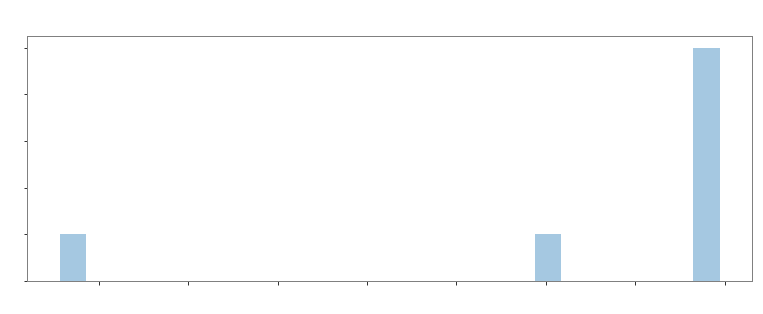

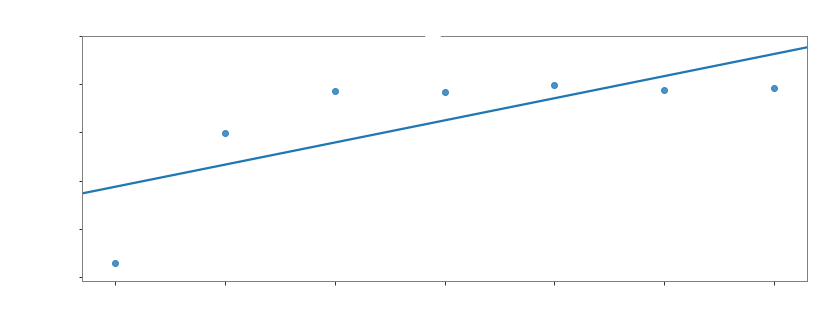

In [11]:
"""
The relation between the F1 score and any non-constant parameters will be plotted below.
Change the order variable to 2 or higher to plot non-linear relations.
"""

order = 1

#  Collect grid search data for visualisation
cols = [k for k in grid[0]['params']]
cols.append('f1')
grid_data = pd.DataFrame([], columns=cols)

#  Get the data
for i in range(len(grid)):
    grid_data.loc[i, 'f1'] = grid[i]['f1']
    for p in [k for k in grid[0]['params']]:
        grid_data.loc[i, p] = str_to_number(grid[i]['params'][p])

#  Convert to floats where possible
for col in grid_data.columns:
    try:
        grid_data[col] = grid_data[col].astype(float)
    except:
        pass

#  Plot distribution of F1 scores
fig = sns.distplot(grid_data['f1'], kde=False, bins=25)
fig.set_ylabel('', color='white')
fig.set_xlabel('', color='white')
fig.set_title('F1 score distribution', color='white', size=30)
plt.setp(fig.get_xticklabels(), color='white', size=20)
plt.setp(fig.get_yticklabels(), color='white', size=20)
plt.show()
    
#  Plot regressions
cols = []
for col in grid_data.columns:
    if grid_data[col].dtype != object and len(grid_data[col].unique()) > 1 and col not in ['scale_pos_weight', 'f1']:
        cols.append(col)

for col in cols:
    rcParams['figure.figsize'] = 13, 4.5
    rcParams["axes.labelsize"] = 20
    rcParams['axes.linewidth'] = 1
    rcParams['axes.edgecolor'] = '.5'
    rcParams['legend.frameon'] = False
    
    fig = sns.regplot(data=grid_data, x=col, y='f1', order=order, ci=None) #  Linear regression; order=2 for non-linear
    fig.set_ylabel('F1 score', color='white')
    fig.set_xlabel('', color='white')
    fig.set_title(col, color='white', size=30)
    plt.setp(fig.get_xticklabels(), color='white', size=20)
    plt.setp(fig.get_yticklabels(), color='white', size=20)
    
    plt.show()